### Imports / Preamble

In [346]:
import numpy as np

from IPython.display import Image, display

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Iteratively inverting a matrix with JAX

If $A \mathbf{x} = \mathbf{b}$, performing gradient descent on the coefficient matrix $A$ requires computing the derivative,

$$
\dfrac{\partial x_k}{\partial A_{ij}}
$$

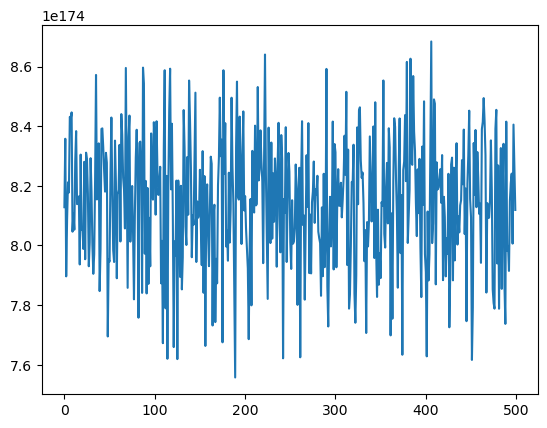

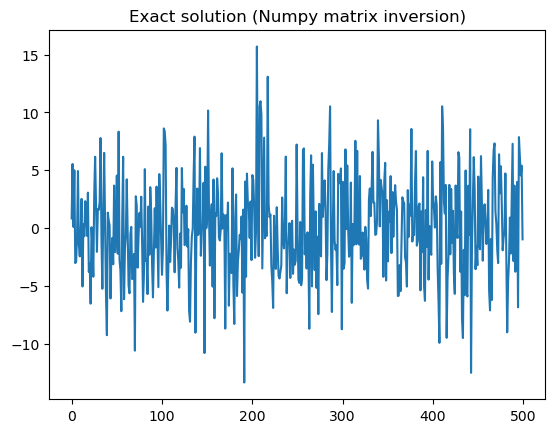

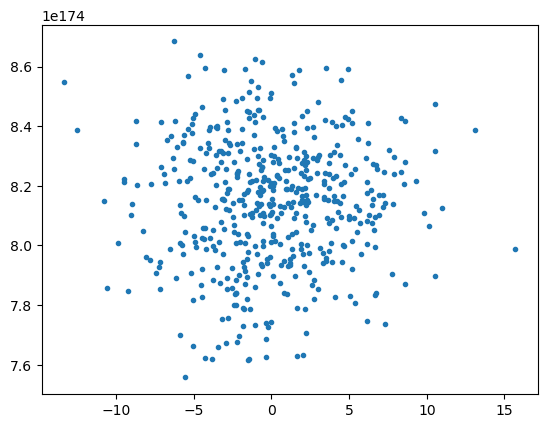

In [353]:
class LinearSolver:

    def __init__(self):
        pass

    def loss(x, y):
        """
        Compute the loss between the output and target values.
        We assume we are using the mean squared error loss as our objective
        """
        return np.mean(np.square(y - x))

    def invert(self, a, b):
        x = np.random.random(b.shape) # random initial guess
        for i in range(1000):
            x = x - 0.01 * (np.dot(a, x) - b)
        return x


# In[ ]:
model = LinearSolver()
a = np.random.random((500, 500))
b = np.random.random(a.shape[0],)

xs = model.invert(a, b)

plt.figure()
plt.plot(xs)

plt.figure()
plt.plot(np.linalg.solve(a, b))
plt.title("Exact solution (Numpy matrix inversion)")

plt.figure()
plt.plot(np.linalg.solve(a, b), xs, '.')

## What if we don't know the derivative analytically?

Let's use slighly different notation, and call our target or output variable $\mathbf{y}$ and the "trainable" set of parameters that we are trying to learn $W$. We just solved the problem 

$$
$\mathbf{y} = W \mathbf{x}$
$$

What about the more common form of linear regression?
$$
\mathbf{y} = W \mathbf{x} + \mathbf{b}
$$
The constant "bias" vector can be absorbed into $W$ by padding the dimensionality of $\mathbf{x}$ and $W$. We might also modify $\mathbf{x}$ in order to minimize the bias term (in ML, subtracting the mean of many observations of $\mathbf{x}$ comes in handy)


Sometimes, due to domain knowledge (like a binary output vector, or known basis functions due to physical symmetries), we are going to end up with slightly more complicated expressions:

$$
\mathbf{y} = \tanh(W \mathbf{x})
$$

Here's a three-layer multilayer perceptron (a type of deep neural network)

$$
\mathbf{y} = \tanh(W_2 \tanh(W_1 \tanh(W_2 \mathbf{x})))
$$





We will talk about the mathematics behind autograd in a future lecture; for now, you just need to know that any mathematical operation for which the forward pass (computing $\mathbf{y}$) is differentiable, JAX can quickly compute its gradient.



## Symbolic differentiation

*Pros*
+ We do it all the time in physics
+ Input formulae defines our exact symbolic expression tree and thus computation graph
+ Uses composition familiar unary differentiation rules (product rule, chain rule, sum rule, certain transcendental functions we've memorized like $e^x, \sin(x)$)

*Cons*
+ The derivative of an expression, and thus computation graph, can grow exponentially with the number of terms in the expression, especially when there are matrices involved
+ (Related to above)Automated chain rule calculations (e.g. Mathematica, Maple, SymPy) use intricate logical rules and grammars; kinda slow
+ We just need a number, not the full expression (wasted compute for single-point gradients)
+ **Easy to make errors**


# Backpropagation

# Automatic differentiation

+ Generate symbolic computation graph for gradient
+ + Doesn't require writing out all terms (full composition), just the node derivatives and their connections


+ Accumulation: graph traversal (recursive). Base case is hitting an input node, or a node with no gradient
+ + A subtlety: memory-efficient gradient accumulation requires parents of a node to be accumulated first, so we need a notion of "ordering" on the graph. This is easy for sequential graphs, but requires a topological sort for arbitrary graphs

# Targeting the Lorenz attractor

+ Dissipative chaotic systems approach attractors, regions of phase space where the dynamics are nontrivial and nonrepeating
+ The forward pass of chaotic systems is extremely sensitive to small changes in initial conditions (some would call this the defining feature of chaos)
+ 

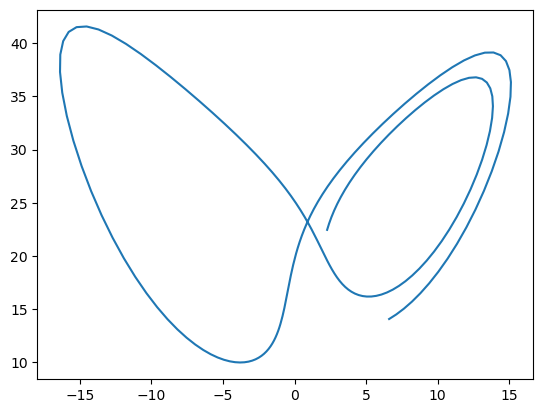

In [339]:
import jax.numpy as np

def lorenz_ode(t, y, sigma=10.0, rho=28.0, beta=8.0 / 3.0):
    x, y, z = y
    # sigma = 10.0
    # rho = 28.0
    # beta = 2.667
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return np.array([xdot, ydot, zdot])

def euler_step(f, t, y, dt):
    return y + dt * f(t, y)

def runge_kutta_step(f, t, y, dt):
    k1 = f(t, y)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2)
    k4 = f(t + dt, y + dt * k3)
    return y + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_ode(f, t0, y0, dt, n_steps):
    y = np.array(y0)
    all_sol = list()
    for _ in range(n_steps):
        y = runge_kutta_step(f, t0, y, dt)
        all_sol.append(y)
    return y, all_sol

def solve_ode2(f, t0, y0, dt, n_steps):
    #y = np.array(y0)
    y = y0
    #for _ in range(n_steps):
    y = runge_kutta_step(f, t0, y, dt)
    return y

y0 = np.array([6.134129, 10.644425, 13.750095])
dt = 0.01
n_steps = 200
y, sols = solve_ode(lorenz_ode, 0.0, y0, dt, n_steps)
sols = np.array(sols)

plt.plot(sols[:, 0], sols[:, 2])

153


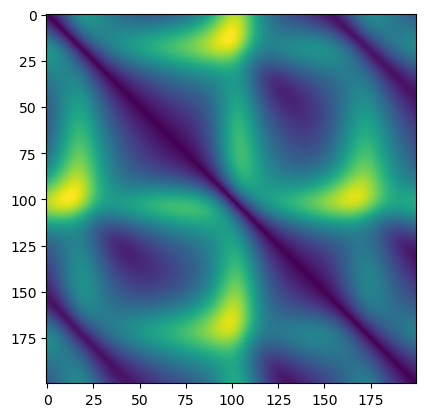

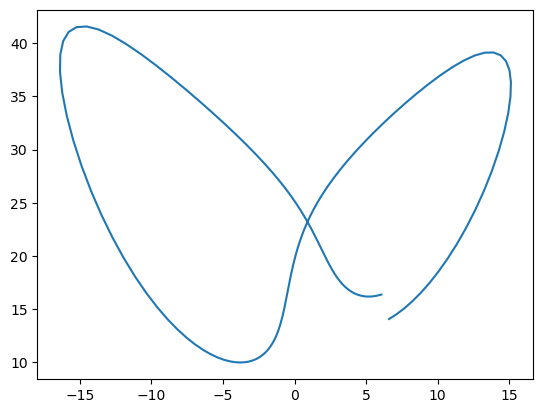

In [341]:
## Pick timescale for integration
dmat = np.sqrt(np.sum((sols[None, ...] - sols[:, None, :])**2, axis=-1))
tau_recur = int(np.argmin(dmat[0][10:]) + 10)

plt.figure()
plt.imshow(dmat)
print(tau_recur)
# from scipy.spatial.distance import cdist, pdist

# pdist(sols).shape

plt.figure()
plt.plot(sols[:tau_recur, 0], sols[:tau_recur, 2])

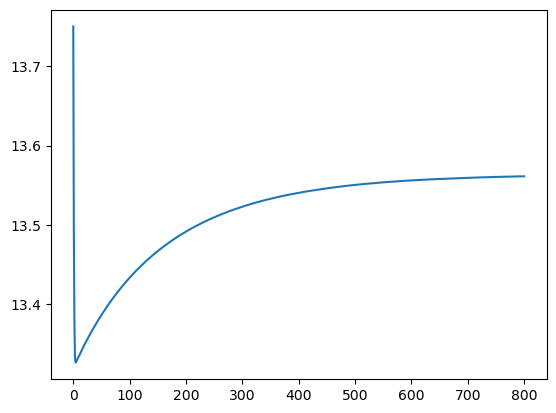

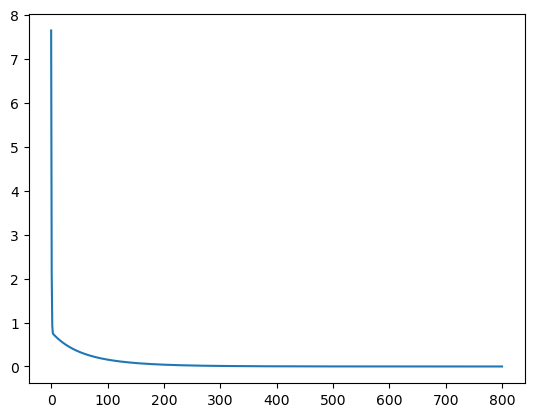

In [342]:
target_point = y0.copy()

# finds fixed points
# def test_func(x0):
#     x = x0.copy()
#     for i in range(50):
#         x = runge_kutta_step(lorenz_ode, 0.0, x, 0.01)
#     return np.sum((x - x0)**2)

def test_func(x0):
    x = x0.copy()
    #closest = np.inf
    for i in range(tau_recur):
        x = runge_kutta_step(lorenz_ode, 0.0, x, 0.01)
    loss = np.sum((x - target_point)**2)
    return loss
    #     closest = np.minimum(closest, loss)
    # return closest

y = y0.copy()
learning_rate = 0.01
all_y = [y.copy()]
for i in range(800):
    # with jax.xla_computation(test_func)(y0) as comp:
    #     print(comp.as_hlo_text())
    constraint_vector = np.array([1, 0, 1])
    y = y - learning_rate * grad(test_func)(y) # * constraint_vector
    all_y.append(y.copy())
all_y = np.array(all_y)


plt.figure()
plt.plot(np.array(all_y)[:, 2])

plt.figure()
plt.plot(vmap(test_func)(np.array(all_y)))

[ 1.4348109  2.4863577 11.666306 ]


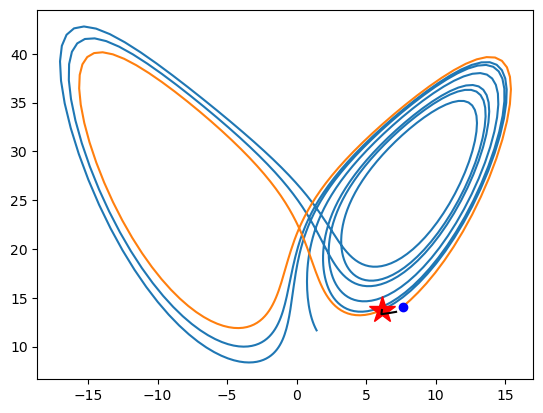

In [343]:
_, sols = solve_ode(lorenz_ode, 0.0, y0, dt, 600)
sols = np.array(sols)
plt.plot(sols[:, 0], sols[:, 2])
print(sols[-1])



_, sols = solve_ode(lorenz_ode, 0.0, all_y[-1], dt, tau_recur)
sols = np.array(sols)
plt.plot(sols[:, 0], sols[:, 2])
plt.plot(sols[0, 0], sols[0, 2], 'ob')
plt.plot(sols[-1, 0], sols[-1, 2], '.k')

plt.plot(target_point[0], target_point[2], '*r', markersize=20)


# plot the sequence of starting values learned during training
plt.plot(all_y[:, 0], all_y[:, 2], 'k')



In [288]:
all_y

DeviceArray([[ 6.2083144, 10.644425 , 14.033107 ],
             [ 6.2852836, 10.644425 , 14.304805 ],
             [ 6.364675 , 10.644425 , 14.565546 ],
             [ 6.446158 , 10.644425 , 14.815699 ],
             [ 6.529431 , 10.644425 , 15.055638 ],
             [ 6.6142206, 10.644425 , 15.28574  ],
             [ 6.70028  , 10.644425 , 15.506377 ],
             [ 6.7873883, 10.644425 , 15.717918 ],
             [ 6.8753457, 10.644425 , 15.920727 ],
             [ 6.963974 , 10.644425 , 16.115156 ],
             [ 7.0531154, 10.644425 , 16.30155  ],
             [ 7.142628 , 10.644425 , 16.480244 ],
             [ 7.2323875, 10.644425 , 16.651562 ],
             [ 7.3222837, 10.644425 , 16.815815 ],
             [ 7.412219 , 10.644425 , 16.973303 ],
             [ 7.502108 , 10.644425 , 17.124317 ],
             [ 7.591876 , 10.644425 , 17.269135 ],
             [ 7.6814575, 10.644425 , 17.408022 ],
             [ 7.770796 , 10.644425 , 17.541233 ],
             [ 7.8598423, 10.64

In [107]:
print(pmap(-9.3))
print(pmap(-9.0))

[ -9.39715  -10.624926  20.425089]
[ -9.124642  -10.6041155  20.395025 ]


In [106]:
from jax import grad, jit, vmap


pmap = lambda x: solve_ode2(lorenz_ode, 0.0, np.array([x, -10., 20.]), dt, n_steps)

grad(pmap)(y0)

ValueError: All input arrays must have the same shape.

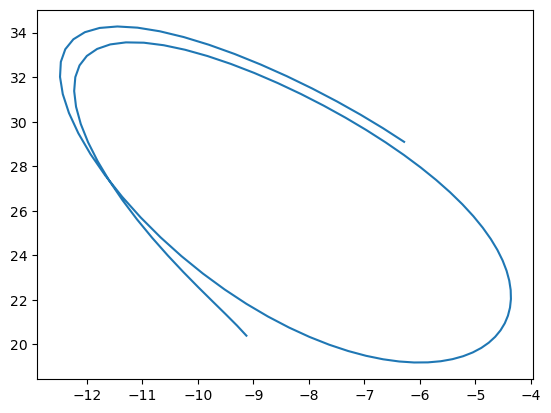

In [85]:
plt.plot(sols[:, 0], sols[:, 2])

In [19]:
plt.plot(y[:, 0], y[:, 2])

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

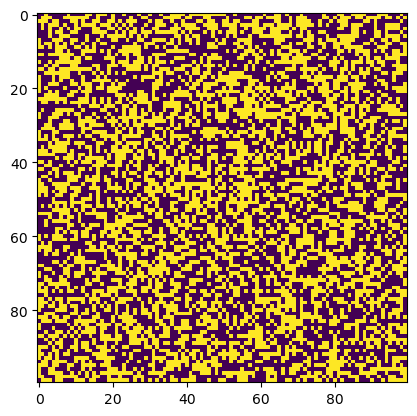

In [13]:
plt.imshow(model.history[1])

# JAX